# *Data Collection and Preprocessing*

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory (
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE    
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset) # 68*32 --> 2176

68

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)
    print(label_batch.numpy())

(256, 256, 3)
[0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 1 0 2 0 0 0 1]


# *Visualize some of the images from our dataset*

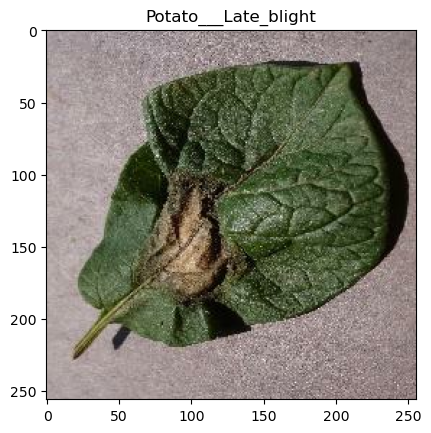

In [10]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
   # plt.axis("off")
    

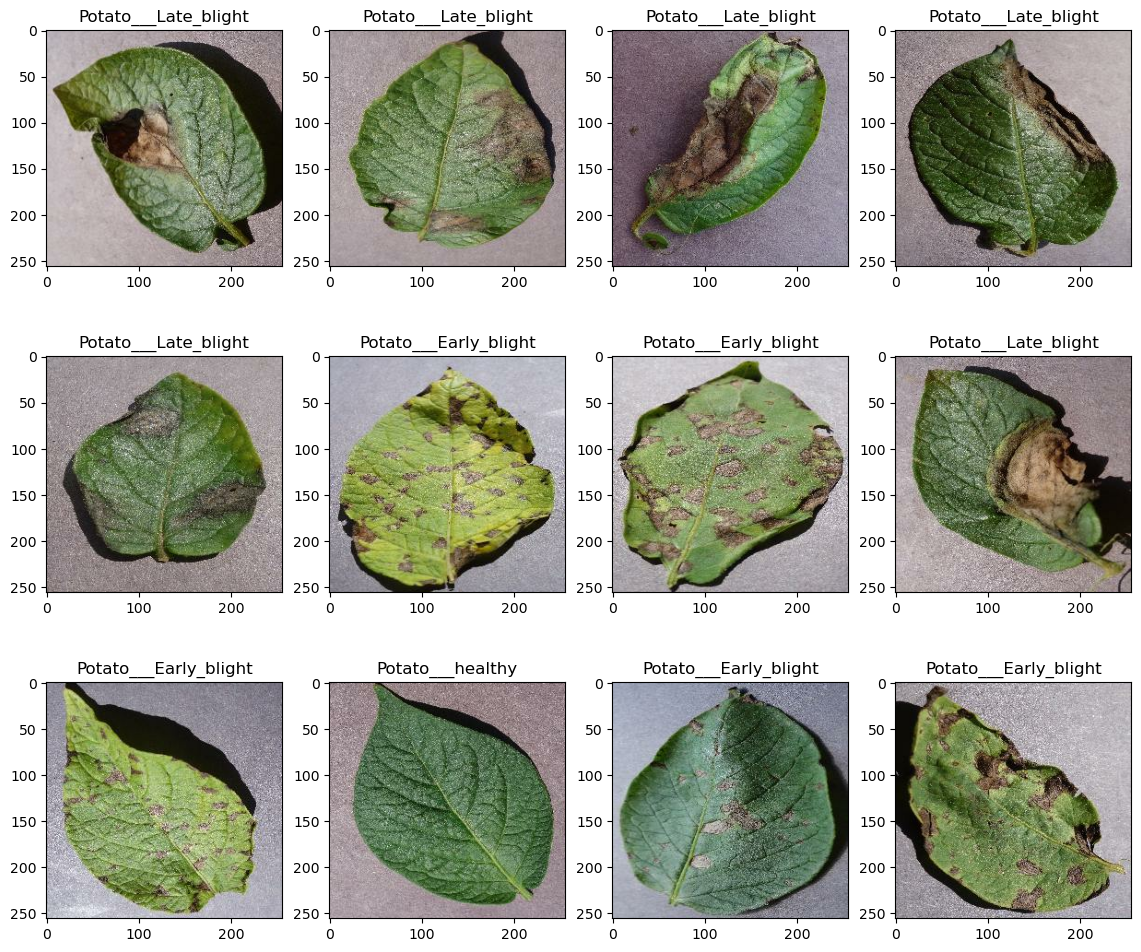

In [11]:
plt.figure(figsize=(14,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1) # matrix 3/4
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
   # plt.axis("off")

## *Splitting Dataset: Train and Test*
Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [13]:
test_size = 0.8
len(dataset) * test_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [17]:
val_ds = dataset.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    assert(train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    if shuffle :
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

In [24]:
# cache, shuffle and pre fatch 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# *Building the Model*
### *Creating a Layer for Resizing and Normalization*
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [26]:
# Updated code without using the experimental namespace
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Moved from experimental.preprocessing to direct layers
  tf.keras.layers.Rescaling(1.0/255)                 # Moved from experimental.preprocessing to direct layers
])

### *Data Augmentation*
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [28]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Removed experimental.preprocessing
  tf.keras.layers.RandomRotation(0.2),                    # Removed experimental.preprocessing
])

### *Applying Data Augmentation to Train Dataset*

In [30]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### *Model Architecture*
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [76]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### *Compiling the Model*
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [35]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4537 - loss: 0.9558 - val_accuracy: 0.5052 - val_loss: 0.8320
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6353 - loss: 0.8246 - val_accuracy: 0.8073 - val_loss: 0.5846
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7802 - loss: 0.5125 - val_accuracy: 0.8542 - val_loss: 0.3338
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8407 - loss: 0.3830 - val_accuracy: 0.8854 - val_loss: 0.2953
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8563 - loss: 0.3767 - val_accuracy: 0.9062 - val_loss: 0.2343
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9047 - loss: 0.2416 - val_accuracy: 0.9062 - val_loss: 0.2593
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8944 - loss: 0.2754 - val_accuracy: 0.8385 - val_loss: 0.4359
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8984 - loss: 0.2549 - val_accuracy: 0.8958 - val_loss

In [37]:
score = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.9950 - loss: 0.0205


In [74]:
score

[0.02258133888244629, 0.9895833134651184]

*You can see above that we get 99.50% accuracy for our test dataset. This is considered to be a pretty good accuracy*

### *Plotting the Accuracy and Loss Curves*

In [41]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}